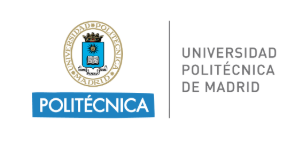

# **CBIR for mushroom classification**
## Anton Aba Varela
## Arturo Pinar Adán
## Nacho Regaña Muñoz



## Preprocessing


In this section the preprocessing of mushroom data is developed. 
The dataset used contains some families of mushrooms. For each family of mushroom (represented in the name of a folder) some different images of mushrooms of the same family are presented. 
The complete dataset can be found at: https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images

However, for simplicity in performance and time, a small dataset have been chosen contained in the folder *data* of this repository. (Link:     ). 

In the following cell the implementation on how the dataset is loaded as well as preprocessed is presented. 

First, the necessary packages are imported in order to perform the load and preprocessing parts. 

After, *drive.mount* function allow to mount the file system used by Google Colab, if this notebook is run out of Google Colab this line can be removed. 

*loc* variable store the path where the dataset is located (the folder of the dataset). In this case the value initialized stands for a path of Google Colab, however depending on the place where the notebook is run this path must be changed. 
The small dataset used is called *MushroomsReduced* therefore the path should finish in that name if the folder name is not changed. *Example: /path where is located the mushroom reduced dataset/MushroomsReduced*.

After the data is stored in two dictionaries (one for color similarity and other for texture similarity). The keys are the names of the mushrooms and each one has assigned a list of transformed images (keeping the same order for both dictionaries)

In [ ]:
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
from google.colab import drive
import numpy as np
import cv2
import os

drive.mount("content", force_remount=False)

loc = "/content/content/MyDrive/Colab Notebooks/IREI/data/MushroomsReduced"

dicColor, dicTexture = {},{}
names=[]
for mushroom in os.listdir(loc):
  folder = loc+"/"+mushroom
  files = os.listdir(folder)
  
  dicColor[mushroom] = [(cv2.imread(folder+"/"+file)) for file in files]
  dicTexture[mushroom] = [(cv2.imread(folder+"/"+file, 0)) for file in files]

  names.append(mushroom)

print("LOAD finished")

##Histograms

In this section the different histograms for color and texture descriptors are presented.

### Local Color Descriptor

In this section the color descriptor creation and the describing process with it for each image is shown. 

The color descriptor is represented by a class named *ColorDescriptor* with three methods: 
- __init__: Represents the constructor of the class. It uses a parameter *bins* in order to set the number of bins used for the histogram of the color descriptor. Moreover, it has been chosen a HSV color descriptor with three different values of bins given as a list. 
- __buildHistogram__: It computes the color histogram used for the HSV descriptor using an image and mask parameter given. 
- __generateFeatures__: In this method is perform all the describing process of the image obtaining as an output the feature vectors. In order to achieve a better accuracy, color histograms are computed in different regions of the image. Therefore, for the image descriptor the image is divided in 5 regions: The top-left corner, the top-right corner, the bottom-right corner, the bottom-left corner, and the center of the image. After, a mask is constructed for each region where the color histogram is computed obtaining as the output the feature vectors for each region. 


In [2]:
import numpy as np
import cv2
import imutils

class ColorDescriptor: 
  def __init__(self, bins): 
    # Number of bins for the color histogram
    self.bins = bins
  

  def buildHistogram(self, img, mask): 
    hist = cv2.calcHist([img], [0,1,2], mask, self.bins,
                        [0, 180, 0, 256, 0, 256])
    # Normalize the histogram
    hist = cv2.normalize(hist, hist).flatten()
    
    return hist

  def generateFeatures(self, img): 
    # Convert the image to HSV
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    features = []

    # compute the center of the image
    (height,width) = img.shape[:2]
    (centerX, centerY) = (int (width * 0.5), int (height * 0.5))
    # Divide the image in regions to compute a region-based histogram
    regions = [(0, centerX, 0, centerY), (centerX, width, 0, centerY), 
               (centerX, width, centerY, height), (0, centerX, centerY, height)]

    # Mask for the center of the image
    (mx, my) = (int (width * 0.75) // 2, int (height * 0.75) // 2)
    mask = np.zeros(img.shape[:2], dtype = "uint8") # black background
    cv2.ellipse(mask, (centerX, centerY), (mx, my), 0, 0, 360, 255, -1)

    # Loop over the regions
    for (startX, endX, startY, endY) in regions: 
      # Construct a mask for each corner of the image, subtracting
      # the elliptical center from it
      cornerMask = np.zeros(img.shape[:2], dtype = "uint8")
      cv2.rectangle(cornerMask, (startX, startY), (endX, endY), 255, -1)
      cornerMask = cv2.subtract(cornerMask, mask)

      # Extract a color histogram from the image creating the feature vector
      hist = self.buildHistogram(img, cornerMask)
      features.extend(hist)

    # Extract a color histogram from the center region and update the feature vector
    hist = self.buildHistogram(img, mask)
    features.extend(hist)

    return features




In this cell is performed all the learning process where the images of the dataset are described by the color descriptor presented above. The feature vectors obtained, are stored in a dictionary.

After a process of trial and error and analyzing the size of our dataset and how similar the color distributions in the dataset are to each other, the following setting is used: 8 bins for Hue channel, 12 bins for saturation channel and 3 bins for the value channel.

The dictionary that store the feature vectors is called *colorData* and its key is a combination of the name of the mushroom with a */* character and the number of the image in the folder. By doing this, is guaranted the uniqueness of the key in order to improve the indexing process in the dictionary later. 
Finally, in *colorData* the value stored for each key is the feature vectors for that image. 

In [3]:
import cv2

# Initialize the color descriptor
# 8 hue bins, 12 saturation bins, 3 value bins
cDescriptor = ColorDescriptor((8, 12, 3))

colorData = {}
# Store the original images to be indexed by the label
originalColorData = {}

indexImgColor = 0
for name in names: 
  for img in dicColor[name]:
    features = cDescriptor.generateFeatures(img)
    colorData[name + "/" + str (indexImgColor)] = features
    originalColorData[name + "/" + str (indexImgColor)] = img
    indexImgColor += 1
  indexImgColor = 0





### LBP Texture Descriptor

In this section the texture descriptor creation and the describing process with it for each image is shown. 

The texture descriptor is represented by a class named *TextureDescriptor* with two methods: 
- __init__: Represents the constructor of the class. It uses two parameters: *p*: Stands for the number of points in a circularly symmetric neighborhood to consider; and *r* represents the radius of the circle for each scale used. More information refer to original *Ojala et al.* paper 

- __generateFeatures__: In this method is performed all the describing process of the image obtaining as an output the feature vectors. The Local Binary Patterns descriptor is used due to its effectiveness at object detection, and therefore, extracting the different head of each mushroom. However, the *lbp* output obtained is not directly usable as a feature vector since it is a 2D array, therefore, to construct the feature vector is call the function *np.histogram* which counts the number of times of each of the LBP prototypes appears. Finally, the feature vectors are returned after being normalized the histogram.

In [4]:
# import the required packages
from skimage import feature
import numpy as np

class TextureDescriptor: 
  def __init__(self, p, r): 
    # p: Number of points in a circularly summetric neighborhood to consider
    # r: Radius of the neighborhood circle considered
    self.p = p
    self.r = r

  def generateFeatures(self, input, eps = 1e-10):
    # Generate LBP representation of the image (input)
    lbp = feature.local_binary_pattern(input, self.p, self.r, method = "uniform")
    (hlbp, _) = np.histogram(lbp.ravel(), 
                             bins = np.arange(0, self.p + 3),
                             range = (0, self.p + 2))
    #Finally return the histogram normalizing it before
    hlbp = hlbp.astype("float")
    hlbp /= (hlbp.sum() + eps)
    return hlbp


In this cell is performed all the learning process where the images of the dataset are described by the texture descriptor presented above and stored in a dictionary to use them after in the distances step.

After a process of trial and error the optimal results have been seen setting *p = 24* and *r = 8*.

The dictionary where the feature vectors are stored is called *textureData* and its key is made by the same procedure as in the dictionary *colorData*. The value stored for each key is the feature vector for that image.


In [5]:
import cv2

tDescriptor = TextureDescriptor(24, 8)

originalTextureData = {}
textureData = {}
indexImgTexture = 0
for name in names: 
  for img in dicTexture[name]:
    features = tDescriptor.generateFeatures(img)
    textureData[name + "/" + str (indexImgTexture)] = features
    originalTextureData[name + "/" + str (indexImgTexture)] = img
    indexImgTexture += 1
  indexImgTexture = 0


## Distances

In this section the comparison between the feature vectors of the query image and the feature vectors of the rest of the images in the dataset is performed. 

On one hand, the chi-square distance is used to compare the feature vectors for color descriptor. 

On the other hand, the euclidean distance is used to compare the feature vectors for texture descriptor. 

### Chi2 - Color

The *ColorComparator* class implements the comparison of the feature vectors for color descriptor generated with the images of the dataset and the features for the color descriptor generated with the query image of the user. 

For this purpose, the chi-square distance have been selected since it is well suited for compare discrete probability distributions and color histograms are by definition probability distributions. Furthermore, the chi-squared distribution allow to change different parameters in order to achieve a higher degree of similarity with human vision. 

 It implements the following methods: 
- __chi2_distance__: Compute the chi-squared distance for two histograms (*histA* and *histB*). *eps* is a residual value for avoid division by zero. 
- __scoreResults__: Using the *queryFeatures* parameter that contains the feature vectors of the query image computes the chi-squared distance with the rest of feature vectors for color descriptor in the dictionary *colorData*. After, it returns a new dictionary which key is the unique label that identifies each image with the notation showed in *Local Color Descriptor* section and the value the distance computed between the features of the query image and the features of that image.

In [6]:
import numpy as np

class ColorComparator: 

  def chi2_distance (self, histA, histB, eps = 1e-10):
    # Compute the chi-squared distance
    d = 0.5 * np.sum([((a - b) ** 2) / (a + b + eps)
    for (a, b) in zip(histA, histB)])
    
    return d
  
  def scoreResults (self, queryFeatures):
    scoredResults = {}

    for (label, imgFeatures) in colorData.items(): 
      # Compare with chi-square distance
      d = self.chi2_distance(imgFeatures, queryFeatures)
      # Update the scoredResults. Key: label of img, value: distance
      scoredResults[label] = d

    return scoredResults




### Euclidean - Texture

The *TextureComparator* class implements the comparison of the feature vector for texture descriptor generated by the images of the dataset and the features for the texture descriptor generated by the query image of the user. 

For this purpose, the euclidean distance have been selected due to its computational simplicity and efficiency for high dimensional spaces.  

 It implements the following methods: 
- __euclidean_distance__: Compute the euclidean distance for two histograms (*histA* and *histB*).  
- __scoreResults__: Using the *queryFeatures* parameter that contains the feature vectors of the query image computes the euclidean distance with the rest of feature vectors for texture descriptor in the dictionary *textureData*. After, it returns a new dictionary which key is the unique label that identifies each image with the notation showed in *LBP Texture Descriptor* section and the value the distance computed between the features of the query image and the features of that image.

In [7]:
import numpy as np
from scipy.spatial import distance as dist

class TextureComparator:

  def euclidean_distance(self, histA, histB):
    return dist.euclidean (histA, histB)
  
  def scoreResults(self, queryFeaturesTexture): 
    scoredResultsTexture = {}

    for (labelTexture, imgFeaturesTexture) in textureData.items():
      d = self.euclidean_distance(imgFeaturesTexture, queryFeaturesTexture)
      scoredResultsTexture[labelTexture] = d

    return scoredResultsTexture

## Search Engine

In this cell is performed the process of ask the user for the query image, the preprocessing of it and the color and texture description for that query image. After, the image is compared with the feature vectors of the color descriptor of the dataset and the same with the feature vectors of the texture descriptor. Finally, the program shows the results of the 10 most similar images combining both descriptors but weighting more the texture descriptor since its better accuracy. 

NOTE: After run this cell the program will ask the user to introduce the path where the query image is located. This path must be the same path (including the name of the image and its extension) according to the file system used. Otherwise, the program will finish and the user will need to run the cell again in order to be able to introduce the path of the query image. 

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# Initialize the descriptor
# 8 hue bins, 12 saturation bins, 3 value bins
cDescriptor = ColorDescriptor((8, 12, 3))
cComparator = ColorComparator()

tDescriptor = TextureDescriptor(24, 8)
tComparator = TextureComparator()

# Ask the user for an image
print("Welcome!")
print("Please, introduce the path of the image")
userPathColor = input("Enter path: ")



if (os.path.isfile(userPathColor) == False):
  print("Image not found. Try again with the correct path")
  print("The path should be: /content/content/MyDrive/folderWhereIsTheImage/imageName.jpg")
else:
  
  userImageColor = cv2.imread(userPathColor)
  print("Your image is this one: ")
  cv2_imshow(userImageColor)

  print("----------------------- RESULTS OF SIMILAR IMAGES --------------------------------")
  print("")
  print("")
  print("")

  print("Searching similarities. Thank you for waiting...")
  
  featuresQueryColor = cDescriptor.generateFeatures(userImageColor)

  finalResultsColor = cComparator.scoreResults(featuresQueryColor)
  
  grayUsImageTexture = cv2.cvtColor(userImageColor, cv2.COLOR_BGR2GRAY)
  featuresQueryTexture = tDescriptor.generateFeatures(grayUsImageTexture)

  finalResultsTexture = tComparator.scoreResults(featuresQueryTexture)

  finalResults = {}


  for key in finalResultsColor: 
    finalResults[key] = finalResultsColor[key] * (finalResultsTexture[key] ** 2)
  
  finalResults = sorted([(v, k) for (k, v) in finalResults.items()])
  
  finalLimit = 10 # number of results displayed
  finalResults = finalResults[:finalLimit]


  print("Showing the most relevant " + str (finalLimit) + " results.")
  for img in finalResults: 
    imgRetrieved = originalColorData[img[1]]
    cv2.putText(imgRetrieved, img[1].split("/")[0], (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                1.0, (0, 0, 255), 3)
    cv2_imshow(imgRetrieved)




